# Import statements
Following packages are necessary:

In [1]:
import sys
sys.path.append("D:\Julian\workspace\endolas\packages")

import random
from endolas import utils
import os
import imageio
import json
from endolas  import closs
from endolas import ccall

from endolas import LASTENSequence

import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as kb
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

from endolas import UNet
from endolas import preprocess_input as pre_une

from matplotlib import pyplot as plt

# Checks
The version of tensorflow as well as the GPU support are checked.

In [2]:
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.get_visible_devices('GPU')

2.2.0-rc3


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  # Disable all GPUS
  tf.config.set_visible_devices([], 'GPU')
  visible_devices = tf.config.get_visible_devices()
  for device in visible_devices:
    assert device.device_type != 'GPU'
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

print(tf.config.get_visible_devices('GPU'))
print(tf.config.get_visible_devices('CPU'))

[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Functionality
Necessary funcionality is added here

In [4]:
def plot_cube(img, x, y, val):
    
    img[y][x] = val
    img[y][x-1] = val
    img[y][x+1] = val
    img[y-1][x] = val
    img[y-1][x-1] = val
    img[y-1][x+1] = val
    img[y+1][x] = val
    img[y+1][x-1] = val
    img[y+1][x+1] = val  

# 8.9) Supervised Euclidean for LASTEN2A_0
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [5]:
tf.keras.backend.clear_session()

store_path = 'test'

path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2A/fix'
path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2A/train'
path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2A/validation'
path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2A/test'

#path_fixed = r'D:\Julian\data\LASTEN2A_0\fix'
#path_train = r'D:\Julian\data\LASTEN2A_0\train'
#path_validation = r'D:\Julian\data\LASTEN2A_0\validation'
#path_test = r'D:\Julian\data\LASTEN2A_0\test'

width = 448
height = 448

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [6]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [7]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [8]:
batch_size=1

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

logger = CSVLogger(store_path + "/log")
timelogger = ccall.TimeHistory(store_path)
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5", period=10)
checker_best = ModelCheckpoint(store_path + "/best_weights.hdf5", save_best_only=True)
callbacks = [timelogger, logger, checker, checker_best]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_met = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='med')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_met])

# Training
Run the training.

In [ ]:
model.fit(train_gen,
          epochs=100,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          #use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

Epoch 1/100


/home/julian/anaconda3/envs/endolas/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


   4/3200 [..............................] - ETA: 1:44:59 - loss: 2855.8376 - med: 46.2291

# Evaluation
Evaluate the trained network

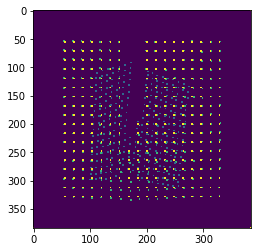

In [14]:
X, y = val_gen[0]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,grid_width*grid_height):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)